### Polynomial Linear Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import seaborn as sns

In [2]:
# used test_...df bc has more dates
euro_c_df_clean = pd.read_csv('test_euro_c_df_clean.csv')

In [3]:
# date -> days since earliest date
date = euro_c_df_clean['acq_date']
x_datetime = pd.to_datetime(date)
reference_date = pd.Timestamp(date.min())       # earliest date, '2020-03-01'
x_timedelta = x_datetime - reference_date
x_days = (x_timedelta.dt.days).to_numpy()

# frp (fire radiative power), latitude, longitude
frp = euro_c_df_clean['frp'].to_numpy()
lat = euro_c_df_clean['latitude'].to_numpy()
long = euro_c_df_clean['longitude'].to_numpy()

# scan, track
scan = euro_c_df_clean['scan'].to_numpy()
track = euro_c_df_clean['track'].to_numpy()

# scale features
scaler = StandardScaler()
frp_scaled = (frp - frp.mean())/frp.std()
lat_scaled = (lat - lat.mean())/lat.std()
long_scaled = (long - long.mean())/long.std()
x_days_scaled = (x_days - x_days.mean())/x_days.std()
scan_scaled = (scan - scan.mean())/scan.std()
track_scaled = (track - track.mean())/track.std()

# set y to frp
y = frp_scaled 

In [4]:
# poly features -- degree 3
poly = PolynomialFeatures(degree=3, include_bias=False)
features = np.hstack([lat_scaled.reshape(-1, 1), long_scaled.reshape(-1, 1), x_days_scaled.reshape(-1, 1), 
    scan_scaled.reshape(-1, 1), track_scaled.reshape(-1, 1)])
poly_features = poly.fit_transform(features)

# add intercept
X_poly = np.hstack([np.ones((poly_features.shape[0], 1)), poly_features])

In [5]:
# use np math to find m
m = np.matmul(np.linalg.inv(np.matmul(X_poly.T, X_poly)), np.matmul(X_poly.T, y))

# calculate predicted y's, residuals, squared residuals, mse, and r^2
ypreds = np.matmul(X_poly, m)
resids = y - ypreds
new_r = []
for r in resids:
    new_r.append(r**2)
mse = sum(new_r) / len(new_r)
print('mse: ', mse)
r2 = 1 - (mse/y.var())
print('r^2: ', r2)


mse:  0.9128304156354483
r^2:  0.08716958436455191


In [6]:
# Cross validation:
from sklearn.model_selection import train_test_split

# split data using train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_poly, y, train_size=0.7)

# calculate m using line_of_best_fit
m = np.matmul(np.linalg.inv(np.matmul(Xtrain.T, Xtrain)), np.matmul(Xtrain.T, ytrain))

# calculate mse and r2 using dict_linreg and print
ypreds = np.matmul(Xtest, m)
resids_t = ytest - ypreds
new_r = []
for r in resids_t:
    new_r.append(r**2)
mse = sum(new_r) / len(new_r)
print('mse: ', mse)
r2 = 1 - (mse/ytest.var())
print('r^2: ', r2)

mse:  0.6638664825916135
r^2:  0.09957155064430412


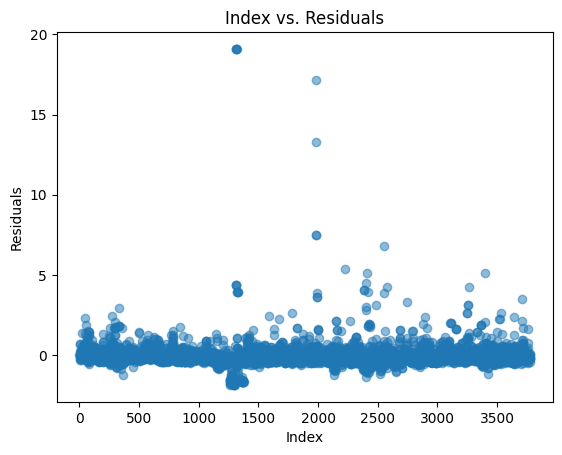

In [7]:
# index vs. residuals
plt.scatter(range(len(X_poly[:,1])), resids, alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Index vs. Residuals')
plt.show()

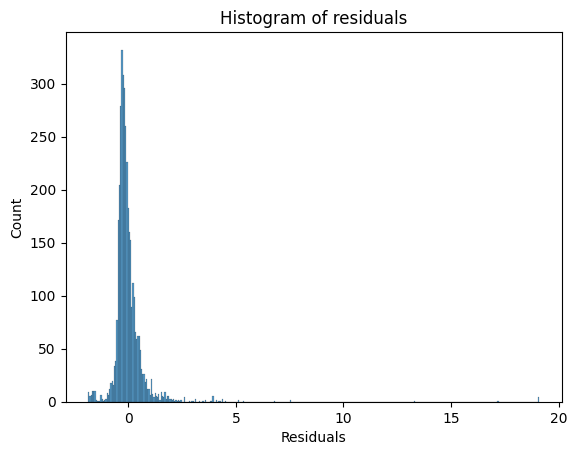

In [8]:
# histogram of residuals
sns.histplot(resids, kde=False)
plt.xlabel('Residuals')
plt.title('Histogram of residuals')
plt.show()

In [9]:
# (px plotting looking for outliers)
import plotly.express as px
euro_c_df_clean_2 = euro_c_df_clean.loc[euro_c_df_clean['latitude'] > 30]
px.scatter(data_frame=euro_c_df_clean_2, x='frp', y='latitude', hover_data = ['frp', 'acq_date'])